In [1]:
from sklearn.datasets import make_classification
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from numpy import mean
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
raw_df = pd.read_csv('week_approach_maskedID_timeseries.csv')

convert_dict = {'nr. sessions': int } #convert nr.sessions to int 
raw_df = raw_df.astype(convert_dict)
raw_df.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4


In [3]:
neg, pos = np.bincount(raw_df['injury'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 42798
    Positive: 575 (1.34% of total)



In [4]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Date')
cleaned_df.pop('Athlete ID')

0         0
1         0
2         0
3         0
4         0
         ..
42793    71
42794    71
42795    71
42796    71
42797    71
Name: Athlete ID, Length: 42798, dtype: int64

In [5]:
cleaned_df.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,avg training success.2,min training success.2,max training success.2,avg recovery.2,min recovery.2,max recovery.2,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2
0,5,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.0,0.0,0.18,0.16,0.20,0,0.718447,1.378882,1.919255
1,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.0,0.18,0.16,0.20,0,0.683544,1.018868,1.490566
2,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.0,0.17,0.16,0.18,0,0.683544,1.018868,1.490566
3,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.0,0.18,0.16,0.18,0,0.683544,1.018868,1.490566
4,6,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.0,0.0,0.17,0.16,0.18,0,2.202247,1.361111,0.618056


In [6]:
y = cleaned_df['injury']
X = cleaned_df.drop('injury', axis=1)

In [7]:
X

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max exertion.2,avg training success.2,min training success.2,max training success.2,avg recovery.2,min recovery.2,max recovery.2,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2
0,5,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.10,0.00,0.00,0.00,0.18,0.16,0.20,0.718447,1.378882,1.919255
1,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.10,0.00,0.00,0.00,0.18,0.16,0.20,0.683544,1.018868,1.490566
2,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.10,0.00,0.00,0.00,0.17,0.16,0.18,0.683544,1.018868,1.490566
3,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.12,0.00,0.00,0.00,0.18,0.16,0.18,0.683544,1.018868,1.490566
4,6,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.12,0.00,0.00,0.00,0.17,0.16,0.18,2.202247,1.361111,0.618056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42793,4,3.0,59.5,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.92,0.76,0.66,0.80,0.20,0.12,0.26,2.479167,1.101852,0.444444
42794,1,6.0,5.8,5.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.19,0.85,0.85,0.85,0.12,0.12,0.12,1.054545,1.288889,1.222222
42795,3,4.0,38.3,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.68,0.75,0.50,0.93,0.32,0.17,0.62,0.750980,0.743689,0.990291
42796,5,2.0,67.0,15.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.80,0.75,0.56,0.91,0.28,0.22,0.41,2.005988,1.238447,0.617375


In [8]:
y

0        0
1        0
2        0
3        0
4        0
        ..
42793    1
42794    1
42795    1
42796    1
42797    1
Name: injury, Length: 42798, dtype: int64

In [9]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 42223, 1: 575})


In [10]:
#split train and test
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [37]:
#model definition
xgb_classifier = XGBClassifier(
    learning_rate =0.003, 
    n_estimators=1000,

)

In [38]:
X_train_smt.shape

(29958, 69)

In [39]:
#generate weights to use on the XGBOOT, this is because the data is so imbalanced
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_smt #provide your own target name
)

xgb_classifier.fit(X_train_smt, y_train_smt, sample_weight=sample_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [40]:
# Performance on the train
auc = roc_auc_score(y_train_smt, xgb_classifier.predict(X_train_smt))
print("Performance sur le train : ", auc)

# Performance on the test
auc = roc_auc_score(y_test_smt, xgb_classifier.predict(X_test_smt))
print("Performance sur le test : ", auc)

Performance sur le train :  0.9245631364089015
Performance sur le test :  0.5929699446607201


In [41]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_smt, xgb_classifier.predict(X_test_smt)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sens_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.14501557632398754
Accuracy  :  0.8549844236760125
Sensitivity  :  0.3236994219653179
Specificity  :  0.3236994219653179
False positive rate  :  0.1377595326438778


In [42]:
tn, fp, fn, tp = confusion_matrix(y_train_smt, xgb_classifier.predict(X_train_smt)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on train set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on train set  : ", acc_)

tn, fp, fn, tp = confusion_matrix(y_test_smt, xgb_classifier.predict(X_test_smt)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on test set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on test set  : ", acc_)

Error rate  on train set :  0.12464116429668202
Accuracy  on train set  :  0.875358835703318
Error rate  on test set :  0.14501557632398754
Accuracy  on test set  :  0.8549844236760125


In [43]:
X_train_smt.iloc[0]

nr. sessions                7.000000
nr. rest days               0.000000
total kms                  18.700000
max km one day              8.500000
total km Z3-Z4-Z5-T1-T2     0.800000
                             ...    
min recovery.2              0.180000
max recovery.2              0.210000
rel total kms week 0_1      0.519444
rel total kms week 0_2      0.444181
rel total kms week 1_2      0.855107
Name: 32895, Length: 69, dtype: float64

In [44]:
k = np.array(X_train_smt.iloc[0]).reshape(1,69)
k

array([[ 7.        ,  0.        , 18.7       ,  8.5       ,  0.8       ,
         0.        ,  1.        ,  0.8       ,  0.8       ,  0.        ,
         0.        ,  2.        ,  2.        ,  0.2       ,  0.16      ,
         0.25      ,  0.84      ,  0.81      ,  0.86      ,  0.21      ,
         0.18      ,  0.28      ,  5.        ,  2.        , 36.        ,
        12.        ,  2.4       ,  0.        ,  1.        ,  2.4       ,
         2.4       ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.3       ,  0.18      ,  0.46      ,  0.76      ,  0.61      ,
         0.85      ,  0.23      ,  0.17      ,  0.3       ,  4.        ,
         3.        , 42.1       , 13.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.33      ,  0.2       ,  0.45      ,
         0.77      ,  0.64      ,  0.84      ,  0.2       ,  0.18      ,
         0.21      ,  0.51944443,  0.44418051,  0.8

In [45]:
xgb_classifier.predict(k)[0]

0

In [46]:
print(classification_report(y_test_smt,xgb_classifier.predict(X_test_smt)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     12667
           1       0.03      0.32      0.06       173

    accuracy                           0.85     12840
   macro avg       0.51      0.59      0.49     12840
weighted avg       0.98      0.85      0.91     12840



In [47]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Injuries: ', np.sum(cm[1]))

True Negatives:  10922
False Positives:  1745
False Negatives:  117
True Positives:  56
Total Injuries:  173


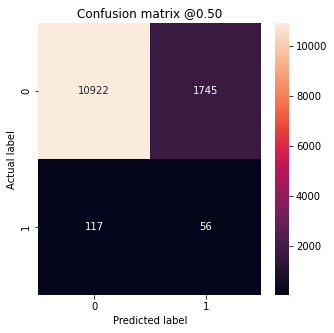

In [48]:
plot_cm(y_test_smt, xgb_classifier.predict(X_test_smt))

Save the model

In [49]:
import pickle
file_name = "xgb_model_weekly.pkl"

# save
pickle.dump(xgb_classifier, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# test
k = np.array(X_test_smt.iloc[700]).reshape(1,69)
xgb_model_loaded.predict(k)[0]

0